In [2]:
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import minimize_scalar
from scipy import optimize

def planck_function(self, wavelength, temperature):
    """ 
    Written by Claude.
    Calculate spectral radiance from Planck's law.
    Args:
        wavelength (float or array): Wavelength in meters
        temperature (float): Temperature in Kelvin

    Returns:
    float or array: Spectral radiance in W.m-2.sr-1.um-1
    """

    wavelength = np.asarray(wavelength)

    # Physical constants
    h = 6.62607015e-34  # Planck constant (J*s)
    c = 299792458  # Speed of light (m/s)
    k = 1.380649e-23  # Boltzmann constant (J/K)

    # Planck's law calculation
    numerator = (2 * h * c**2) / (wavelength**5)
    denominator = np.exp((h * c) / (wavelength * k * temperature)) - 1

    # Spectral radiance (W.m-2.sr-1.um-1)
    spectral_radiance = numerator / denominator

    #convert to W.m^-2.sr^-1.micron
    spectral_radiance *= 1e-6

    return spectral_radiance

def planck_inv(self, wavelength, spectral_radiance):
    """ 
    Written by Claude.
    Calculate temperature from spectral radiance using Planck's law.

    Args:
        wavelength (float): Wavelength in meters
        spectral_radiance (float): Spectral radiance in W.m-2.sr-1.um-1

    Returns:
        float: Temperature in Kelvin
    """
    # Physical constants
    h = 6.62607015e-34  # Planck constant (J*s)
    c = 299792458       # Speed of light (m/s)
    k = 1.380649e-23    # Boltzmann constant (J/K)
    
    # Objective function to minimize
    def objective(T):
        numerator = (2 * h * c**2) / (wavelength**5)
        exponent = (h * c) / (wavelength * k * T)
        denominator = np.exp(exponent) - 1
        calculated_radiance = (numerator / denominator) * 1e-6
        
        return abs(calculated_radiance - spectral_radiance)
    
    # Solve using bounded optimization
    result = optimize.minimize_scalar(objective, bounds=(1, 10000), method='bounded')
    
    return result.x

def brightness_temperature(self, radiance, band_center, band_width):
    """ 
    Written by Claude.

    Calculate brightness temperature for a given rectangular bandpass.

    Implements numerical integration over a rectangular bandpass defined
    by its center wavelength and width. The bandpass is assumed to have
    unity transmission within its bounds and zero outside.

    Args:
        radiance (float): Observed radiance in W.m-2.sr-1.um-1
        band_center (float): Center wavelength of bandpass in meters
        band_width (float): Width of bandpass in meters

    Returns:
        float: Brightness temperature in Kelvin

    Raises:
        ValueError: If band_width <= 0 or band_center <= band_width /2
    """

    # Validate input
    if band_width <= 0:
        raise ValueError("Band width must be positive")
    if band_center <= band_width / 2:
        raise ValueError("Invalid band center and width")

    # Physical constants
    h = 6.626e-34  # Planck's constant (J·s)
    c = 3e8        # Speed of light (m/s)
    k = 1.380e-23  # Boltzmann constant (J/K)

    # Define integration bounds
    lower_wavelength = band_center - band_width / 2
    upper_wavelength = band_center + band_width / 2

    # Objective function for integration
    def brightness_temp_integrand(wavelength, temperature):
        numerator = (2 * h * c**2) / (wavelength**5)
        exponent = (h * c) / (wavelength * k * temperature)
        denominator = np.exp(exponent) - 1
        return (numerator / denominator) * 1e-6

    # Objective function to minimize
    def objective(T):
        integrated_radiance, _ = integrate.quad(
            brightness_temp_integrand, 
            lower_wavelength, 
            upper_wavelength, 
            args=(T,)
        )
        return abs(integrated_radiance - radiance)

    # Solve using bounded optimization
    result = minimize_scalar(objective, bounds=(1, 10000), method='bounded')
    
    return result.x

def radiance(temperature, band_center, band_width):
    """ 
    Written by Claude.
    Calculate band-integrated radiance for a given temperature and rectangular bandpass.

    Args:
        temperature (float): Temperature in Kelvin
        band_center (float): Center wavelength of bandpass in meters
        band_width (float): Width of bandpass in meters

    Returns:
        float: Band-integrated radiance in W.m-2.sr-1
    """
    # Validate input
    if temperature <= 0:
        raise ValueError("Temperature must be positive.")
    if band_width <= 0:
        raise ValueError("Band width must be positive")
    if band_center <= band_width / 2:
        raise ValueError("Invalid band center and width")
    
    # Define integration bounds
    lower_wavelength = band_center - band_width / 2
    upper_wavelength = band_center + band_width / 2

    # Physical constants
    h = 6.62607015e-34  # Planck constant (J*s)
    c = 299792458       # Speed of light (m/s)
    k = 1.380649e-23    # Boltzmann constant (J/K)

    # Integration function
    def planck_integrand(wavelength):
        numerator = (2 * h * c**2) / (wavelength**5)
        denominator = np.exp((h * c) / (wavelength * k * temperature)) - 1
        return (numerator / denominator) * 1e-6

    # Perform numerical integration
    integrated_radiance, _ = integrate.quad(
        planck_integrand, 
        lower_wavelength, 
        upper_wavelength
    )
    
    return integrated_radiance

def calculate_NEDT(self, temperature, NER, band_center, band_width):
    """ 
        Written by Claude.
        Calculate the noise-equivalent differential temperature (NEDT)
        for given scene temperature and noise-equivalent radiance (NER).

        Uses numerical derivative of band-integrated radiance with respect
        to temperature to determine the temperature uncertainty corresponding
        to the NER.

    Args:
        temperature (float): Scene temperature in Kelvin
        NER (float): Noise-equivalent radiance in W.m-2.sr-1
        band_center (float): Center wavelength of bandpass in meters
        band_width (float): Width of bandpass in meters

    Returns:
        float: NEDT in Kelvin

    Raises:
        ValueError: If temperature <= 0, NER <= 0, band_width <= 0,
        or band_center <= band_width/2
    """
    # Validate input parameters
    if temperature <= 0:
        raise ValueError("Temperature must be positive")
    if NER <= 0:
        raise ValueError("Noise-equivalent radiance must be positive")
    if band_width <= 0:
        raise ValueError("Band width must be positive")
    if band_center <= band_width / 2:
        raise ValueError("Invalid band center and width")

    # Small temperature perturbation
    delta_T = 0.1  # Kelvin

    # Calculate radiance at current and perturbed temperatures
    R0 = self.radiance(temperature, band_center, band_width)
    R1 = self.radiance(temperature + delta_T, band_center, band_width)

    # Numerical derivative (radiance change per Kelvin)
    dR_dT = (R1 - R0) / delta_T

    # NEDT calculation
    NEDT = NER / abs(dR_dT)

    return NEDT





Wavelength of max index position for solar spectrum 501.3249324932493 nm
Recovered temperature from the calculated solar spectral radiance: 5778.0 K


C:\Users\miro2306\AppData\Local\Temp\ipykernel_20460\2420673316.py:27: RuntimeWarning: overflow encountered in exp
  denominator = np.exp((h * c) / (wavelength * k * temperature)) - 1


Text(0, 0.5, 'Radiance (W.m-2.sr-1.um-1)')

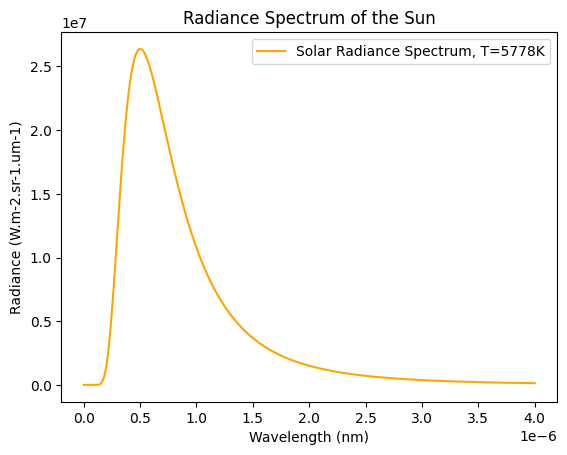

In [47]:
'''
Problem 3.1: Basic Validation and Bandpass Effects
• Plot Planck function for T = 5778K (Sun), 300K (Earth), 100K (Europa)
• Verify planck inv recovers input temperatures
• Show how band-integrated radiance varies with temperature for different bandwidths
'''

#Generating the solar spectrum for the sun, and recovering the temperature
wavelengths = np.linspace(1e-9, 4000e-9, 10000)
solar_temp, earth_temp, europa_temp = 5778, 300, 100

#Generating solar spectrum
solar_spectral_radiance = planck_function(None, wavelengths, solar_temp)

#printing the wavelength of the maximum radiance
max_index = np.argmax(solar_spectral_radiance)
print("Wavelength of max index position for solar spectrum", wavelengths[max_index]*(1e9), 'nm')

#printing the recovered temperature from the spectrum
print("Recovered temperature from the calculated solar spectral radiance:", planck_inv(None, wavelengths[max_index], solar_spectral_radiance[max_index]*1e6), 'K')

#plotting solar spectrum
plt.plot(wavelengths, solar_spectral_radiance, c='orange', label=f'Solar Radiance Spectrum, T={solar_temp}K')
plt.legend()
plt.title("Radiance Spectrum of the Sun")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Radiance (W.m-2.sr-1.um-1)")

Wavelength of max index position for earth spectrum 9.659196591965923 microns
Recovered temperature from the calculated earth spectral radiance: 300.0 K


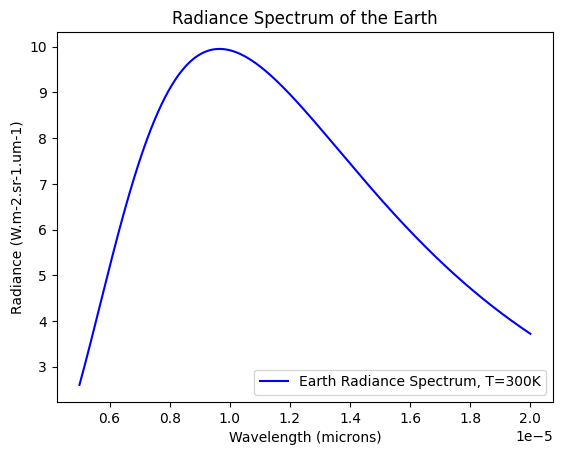

In [46]:
#Generating the earth spectrum, and recovering the temperature
wavelengths = np.linspace(5000e-9, 20000e-9, 100000)
earth_temp = 300

#Generating earth spectrum
earth_spectral_radiance = planck_function(None, wavelengths, earth_temp)

#printing the wavelength of the maximum radiance
max_index2 = np.argmax(earth_spectral_radiance)
print("Wavelength of max index position for earth spectrum", wavelengths[max_index2]*(1e6), 'microns')

#printing the recovered temperature from the spectrum
print("Recovered temperature from the calculated earth spectral radiance:", planck_inv(None, wavelengths[max_index2], earth_spectral_radiance[max_index2]*1e6), 'K')

#plotting solar spectrum
plt.plot(wavelengths, earth_spectral_radiance, c='blue', label=f'Earth Radiance Spectrum, T={earth_temp}K')
plt.title("Radiance Spectrum of the Earth")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Radiance (W.m-2.sr-1.um-1)")
plt.legend()

Wavelength of max index position for europa spectrum 28.97746977469775 microns
Recovered temperature from the calculated europa spectral radiance: 100.00000000000001 K


Text(0, 0.5, 'Radiance (W.m-2.sr-1.um-1)')

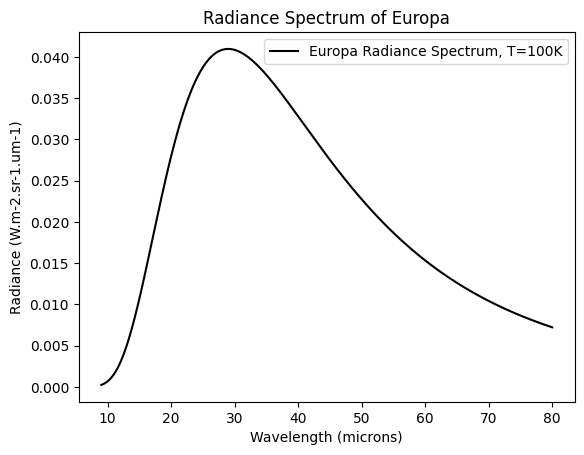

In [51]:
#Generating the europa spectrum, and recovering the temperature
wavelengths = np.linspace(9000e-9, 80000e-9, 100000)
europa_temp = 100

#Generating europa spectrum
europa_spectral_radiance = planck_function(None, wavelengths, europa_temp)

#printing the wavelength of the maximum radiance
max_index = np.argmax(europa_spectral_radiance)
print("Wavelength of max index position for europa spectrum", wavelengths[max_index]*(1e6), 'microns')

#printing the recovered temperature from the spectrum
print("Recovered temperature from the calculated europa spectral radiance:", planck_inv(None, wavelengths[max_index], europa_spectral_radiance[max_index]*1e6), 'K')

#plotting solar spectrum
plt.plot(wavelengths, europa_spectral_radiance, c='black', label=f'Europa Radiance Spectrum, T={europa_temp}K')
plt.legend()
plt.xticks(ticks=[10e-6, 20e-6, 30e-6, 40e-6, 50e-6, 60e-6, 70e-6, 80e-6], labels=[10, 20, 30, 40, 50, 60, 70, 80])
plt.title("Radiance Spectrum of Europa")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Radiance (W.m-2.sr-1.um-1)")

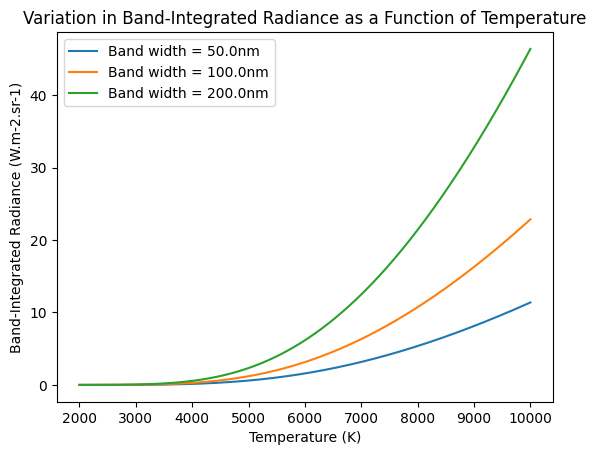

In [64]:
"""
Problem 1 part c: Show how band-integrated radiance varies with temperature for different bandwidths
"""

#defining the parameters for the radiance function, which takes the temperature, band center and band width
temperatures = np.linspace(2000, 10000, 1000)
band_center = 500e-9 #nm
band_widths = [50e-9, 100e-9, 200e-9]

#for each band width, calculate the band-integrated radiance for each temperature
integrated_radiances = []
for band_width in band_widths:
    integrated_radiance = np.array([radiance(temperature=temp, band_center=band_center, band_width=band_width) for temp in temperatures])
    integrated_radiances.append(integrated_radiance)

#plot the radiances for each band width
for i, radiances in enumerate(integrated_radiances):
    plt.plot(temperatures, radiances, label=f'Band width = {band_widths[i]*1e9}nm')

#titles and axis labels
plt.title("Variation in Band-Integrated Radiance as a Function of Temperature")
plt.xlabel("Temperature (K)")
plt.ylabel("Band-Integrated Radiance (W.m-2.sr-1)")
plt.legend()
